In [20]:
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
import time

# 1. Buat dataset 2D sederhana
np.random.seed(42)
X = np.random.rand(1000, 2).astype('float32')  # 1000 titik 2D
query = np.array([[0.5, 0.5]], dtype='float32')  # query di tengah


In [21]:
# 2. Exact NN dengan IndexFlatL2 (brute force tapi cepat)
index_flat = faiss.IndexFlatL2(2)   # L2 = Euclidean distance
index_flat.add(X)

start = time.time()
D_flat, I_flat = index_flat.search(query, 3)  # cari 3 tetangga terdekat
end = time.time()
time_flat = end - start

In [22]:
# 3. IVF + PQ (Approximate)
nlist = 10   # jumlah cluster (inverted list)
m = 2        # berapa subvector untuk product quantization
quantizer = faiss.IndexFlatL2(2)   # dipakai IVF untuk cluster awal
index_ivfpq = faiss.IndexIVFPQ(quantizer, 2, nlist, m, 8)  # 8 bit per subvector

index_ivfpq.train(X)  # training centroid
index_ivfpq.add(X)

start = time.time()
D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
end = time.time()
time_ivfpq = end - start

# 4. Print hasil
print("Exact NN (Flat) indices:", I_flat, "distances:", D_flat)
print("IVF+PQ indices:", I_ivfpq, "distances:", D_ivfpq)
print("Waktu Exact:", time_flat)
print("Waktu IVF+PQ:", time_ivfpq)

Exact NN (Flat) indices: [[137 170 750]] distances: [[0.00013095 0.00077404 0.00079751]]
IVF+PQ indices: [[137 170 750]] distances: [[0.00012945 0.00079226 0.00080067]]
Waktu Exact: 0.008997440338134766
Waktu IVF+PQ: 0.001004934310913086


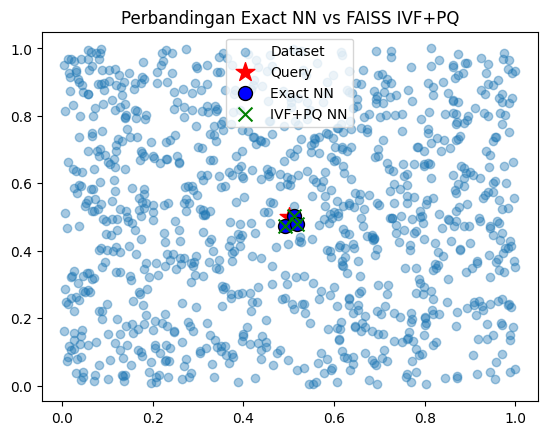

In [23]:
# 5. Visualisasi
plt.scatter(X[:,0], X[:,1], alpha=0.4, label="Dataset")
plt.scatter(query[:,0], query[:,1], c='red', marker='*', s=200, label="Query")

# Tetangga dari Flat
plt.scatter(X[I_flat[0],0], X[I_flat[0],1], c='blue', s=100, edgecolor='k', label="Exact NN")

# Tetangga dari IVF+PQ
plt.scatter(X[I_ivfpq[0],0], X[I_ivfpq[0],1], c='green', marker='x', s=100, label="IVF+PQ NN")

plt.legend()
plt.title("Perbandingan Exact NN vs FAISS IVF+PQ")
plt.show()

# Percobaan Metric Distance

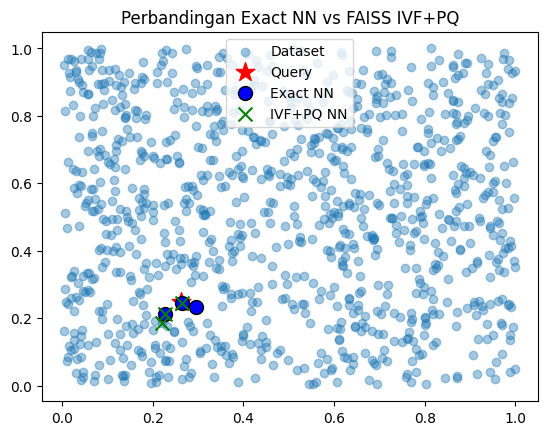

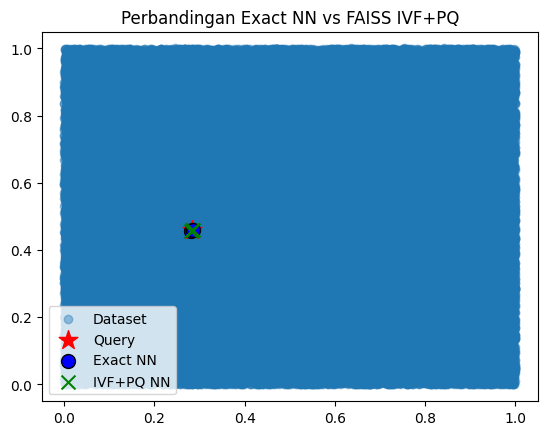

In [24]:
sizes = [1000, 100000]
dimensions = [2, 5]

results = []

for size in sizes:
    for d in dimensions:
        # 1. Buat dataset
        np.random.seed(42)
        X = np.random.rand(size, d).astype('float32')
        query = np.random.rand(1, d).astype('float32')  # query random
        
        # 2. Exact NN dengan IndexFlatL2 (brute force tapi cepat)
        index_flat = faiss.IndexFlatL2(d)   # L2 = Euclidean distance
        index_flat.add(X)
        
        start = time.time()
        D_flat, I_flat = index_flat.search(query, 3)  # cari 3 tetangga terdekat
        end = time.time()
        time_flat = end - start
        
        # 3. IVF + PQ (Approximate)
        nlist = 10 if size < 50000 else 100   # jumlah cluster (inverted list)
        m = d if d < 8 else 8      # berapa subvector untuk product quantization
        quantizer = faiss.IndexFlatL2(d)   # dipakai IVF untuk cluster awal
        index_ivfpq = faiss.IndexIVFPQ(quantizer, d, nlist, m, 8)  # 8 bit per subvector
        
        index_ivfpq.train(X)  # training centroid
        index_ivfpq.add(X)
        
        start = time.time()
        D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
        end = time.time()
        time_ivfpq = end - start
        
        # 5. Visualisasi
        if d == 2:
            plt.scatter(X[:,0], X[:,1], alpha=0.4, label="Dataset")
            plt.scatter(query[:,0], query[:,1], c='red', marker='*', s=200, label="Query")
            
            # Tetangga dari Flat
            plt.scatter(X[I_flat[0],0], X[I_flat[0],1], c='blue', s=100, edgecolor='k', label="Exact NN")
            
            # Tetangga dari IVF+PQ
            plt.scatter(X[I_ivfpq[0],0], X[I_ivfpq[0],1], c='green', marker='x', s=100, label="IVF+PQ NN")
            
            plt.legend()
            plt.title("Perbandingan Exact NN vs FAISS IVF+PQ")
            plt.show()
            plt.close()

        # --- Simpan hasil ke list ---
        results.append({
            "Jumlah data": f"{size:,}",
            "Dimensi": d,
            "Exact NN (Flat) indices": I_flat.tolist(),
            "Exact NN (Flat) distances": D_flat.tolist(),
            "IVF+PQ indices": I_ivfpq.tolist(),
            "IVF+PQ distances": D_ivfpq.tolist(),
            "Waktu Exact (s)": round(time_flat, 6),
            "Waktu IVF+PQ (s)": round(time_ivfpq, 6)
        })

# --- Convert ke DataFrame ---
df = pd.DataFrame(results)

In [25]:
# --- Tampilkan tabel rapi ---
print(df.to_string(index=False))

Jumlah data  Dimensi Exact NN (Flat) indices                                                 Exact NN (Flat) distances          IVF+PQ indices                                                           IVF+PQ distances  Waktu Exact (s)  Waktu IVF+PQ (s)
      1,000        2       [[112, 535, 777]]   [[2.116181349265389e-05, 0.0013761133886873722, 0.0023510854225605726]]       [[112, 777, 548]]     [[1.6702339053153992e-05, 0.002358432859182358, 0.005398830398917198]]         0.000000               0.0
      1,000        5        [[988, 780, 27]]       [[0.01057143323123455, 0.022529801353812218, 0.040967851877212524]]        [[988, 780, 27]]        [[0.01058318093419075, 0.022596299648284912, 0.040768519043922424]]         0.000000               0.0
    100,000        2   [[3565, 69502, 3715]] [[4.811910002899822e-06, 1.0597152140690014e-05, 1.5256491678883322e-05]]   [[3565, 69502, 3715]] [[4.7639477998018265e-06, 1.1626863852143288e-05, 1.4125136658549309e-05]]         0.001002       